In [1]:
from utils import *
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import time
import random
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['negative', 'positive']
10662
10662


In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(trainset.data, trainset.target,
                                                    test_size = 0.2)

In [4]:
concat = ' '.join(trainset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 20332
Most common words [('film', 1453), ('movie', 1270), ('one', 727), ('like', 721), ('story', 477), ('much', 386)]
Sample data [556, 2600, 3622, 11345, 36, 8710, 219, 150, 19, 3998] ['rock', 'destined', '21st', 'centurys', 'new', 'conan', 'hes', 'going', 'make', 'splash']


In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
def get_one_triplet(input_data, input_labels, n_labels):
    index = np.random.choice(n_labels, 2, replace=False)
    label_positive = index[0]
    label_negative = index[1]

    indexes = np.where(input_labels == index[0])[0]
    np.random.shuffle(indexes)

    data_anchor = input_data[indexes[0], :]
    data_positive = input_data[indexes[1], :]

    indexes = np.where(input_labels == index[1])[0]
    np.random.shuffle(indexes)
    data_negative = input_data[indexes[0], :]

    return data_anchor, data_positive, data_negative, label_positive, label_positive, label_negative

def compute_euclidean_distance(x, y):
    d = tf.square(tf.subtract(x, y))
    return tf.sqrt(tf.reduce_sum(d))

def compute_triplet_loss(anchor_feature, positive_feature, negative_feature, margin=0.01):
    d_p_squared = tf.square(compute_euclidean_distance(anchor_feature, positive_feature))
    d_n_squared = tf.square(compute_euclidean_distance(anchor_feature, negative_feature))
    loss = tf.maximum(0., d_p_squared - d_n_squared + margin)
    return tf.reduce_mean(loss), tf.reduce_mean(d_p_squared), tf.reduce_mean(d_n_squared)

In [7]:
class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output,margin=0.2):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer,reuse=reuse)
        
        def rnn(embedded,reuse=False):
            with tf.variable_scope('model', reuse=reuse):
                rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
                outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded, dtype = tf.float32)
                W = tf.get_variable('w',shape=(size_layer, dimension_output),initializer=tf.orthogonal_initializer())
                b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
                return tf.matmul(outputs[:, -1], W) + b
            
        with tf.device('/cpu:0'):    
            self.ANCHOR = tf.placeholder(tf.int32, [None, None])
            self.POSITIVE = tf.placeholder(tf.int32, [None, None])
            self.NEGATIVE = tf.placeholder(tf.int32, [None, None])
            self.Y_ANCHOR = tf.placeholder(tf.int32, [None])
            self.Y_POSITIVE = tf.placeholder(tf.int32, [None])
            self.Y_NEGATIVE = tf.placeholder(tf.int32, [None])
            encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
            anchor_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.ANCHOR)
            positive_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.POSITIVE)
            negative_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.NEGATIVE)
            self.output_anchor = rnn(anchor_embedded,False)
            self.output_positive = rnn(positive_embedded,True)
            self.output_negative = rnn(negative_embedded,True)
            self.cost, positives, negatives = compute_triplet_loss(self.output_anchor, 
                                                          self.output_positive, 
                                                          self.output_negative)
            self.optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(self.cost)

In [8]:
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = len(trainset.target_names)
maxlen = 50
batch_size = 128

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,len(dictionary),dimension_output)
sess.run(tf.global_variables_initializer())

In [10]:
train_X = str_idx(train_X,dictionary,maxlen)
test_X = str_idx(test_X,dictionary,maxlen)

In [11]:
for i in range(10):
    lasttime = time.time()
    batch_anchor = np.zeros((batch_size,maxlen))
    batch_positive = np.zeros((batch_size,maxlen))
    batch_negative = np.zeros((batch_size,maxlen))
    batch_y_anchor = np.zeros((batch_size))
    batch_y_positive = np.zeros((batch_size))
    batch_y_negative = np.zeros((batch_size))
    for k in range(batch_size):
        batch_anchor[k], batch_positive[k], batch_negative[k], batch_y_anchor[k], batch_y_positive[k], batch_y_negative[k] = get_one_triplet(train_X, train_Y, dimension_output)
    loss, _ = sess.run([model.cost,model.optimizer],
                       feed_dict={model.ANCHOR:batch_anchor,
                                  model.POSITIVE:batch_positive,
                                  model.NEGATIVE:batch_negative,
                                  model.Y_ANCHOR:batch_y_anchor,
                                  model.Y_POSITIVE:batch_y_positive,
                                  model.Y_NEGATIVE:batch_y_negative})
    print('epoch: %d, loss: %f'%(i+1,loss))

epoch: 1, loss: 0.000000
epoch: 2, loss: 4.933203
epoch: 3, loss: 10.419333
epoch: 4, loss: 0.000000
epoch: 5, loss: 0.000000
epoch: 6, loss: 7.707937
epoch: 7, loss: 0.000000
epoch: 8, loss: 3.788496
epoch: 9, loss: 0.000000
epoch: 10, loss: 0.000000


In [12]:
logits_train = sess.run(model.output_positive,feed_dict={model.POSITIVE:train_X})
logits_test = sess.run(model.output_positive,feed_dict={model.POSITIVE:test_X})
logits_test.shape

(2133, 2)

In [24]:
from scipy.spatial.distance import cdist
label_test = []
for i in range(logits_test.shape[0]):
    label_test.append(train_Y[np.argsort(cdist(logits_train, [logits_test[i,:]], 'cosine').ravel())[0]])
print(metrics.classification_report(test_Y, label_test, target_names = trainset.target_names))

#print(metrics.classification_report(test_Y, np.argmax(logits_test,axis=1), target_names = trainset.target_names))

             precision    recall  f1-score   support

   negative       0.50      0.52      0.51      1054
   positive       0.51      0.48      0.50      1079

avg / total       0.50      0.50      0.50      2133



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

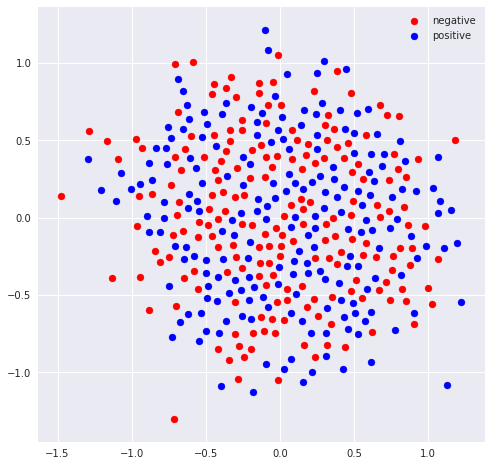

In [30]:
ax_min = np.min(logits_test,0)
ax_max = np.max(logits_test,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = ['b','r']
for i in range(logits_test.shape[0]):
    dist = np.sum((logits_test[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [logits_test[i]]]
    plt.scatter(logits_test[i,0],logits_test[i,1],c=colors[test_Y[i]])
plt.legend(['negative','positive'])
plt.show()